In [2]:
%matplotlib inline

import os
os.chdir('/Users/Sinead/DC-project/')
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import script

import plotly 
plotly.offline.init_notebook_mode()

/Users/Sinead/anaconda/envs/project/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
# recent: trying to do with pre_700 rather than post_700

In [4]:
plt.ioff()

In [5]:
PrePathDicom = '/Volumes/Backup Data/ASDH Samples/Sample1/Pre-operative/R-N11-109/HeadSpi  1.0  J40s  3'
PostPathDicom = '/Volumes/Backup Data/ASDH Samples/Sample1/Post-operative/R-N11-109/HeadSpi  1.0  J40s  3'
pre_700_threshold=script.threshim(400,'none',PrePathDicom)
pre_700=script.vtk2np(pre_700_threshold,PrePathDicom)
post_700_threshold=script.threshim(700,'none',PostPathDicom)
post_700=script.vtk2np(post_700_threshold,PostPathDicom)

In [6]:
pre_700[:,:,90]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [9]:
numpy_array=post_700[:,:,100]
indices = np.nonzero(numpy_array)
x = indices[1]
y = indices[0]
points = np.zeros((len(indices[1]),2))
for i in range(len(indices[1])):
    points[i, 0] = x[i]
    points[i, 1] = y[i]

In [10]:
# https://github.com/hbldh/b2ac/tree/master/b2ac

import numpy as np
import b2ac.preprocess
import b2ac.fit
import b2ac.conversion

# Fit using NumPy methods in double precision.
conic_numpy = b2ac.fit.fit_improved_B2AC_numpy(points)
# Fit using own written methods in double precision.
conic_double = b2ac.fit.fit_improved_B2AC_double(points)
# Fit using own written methods in 64-bit integer precision.
conic_int = b2ac.fit.fit_improved_B2AC_int(points)

# Convert from conic coefficient form to general ellipse form.
general_form_numpy = b2ac.conversion.conic_to_general_1(conic_numpy)
#general_form_numpy[0][0] += x_mean
#general_form_numpy[0][1] += y_mean

general_form_double = b2ac.conversion.conic_to_general_1(conic_double)
#general_form_double[0][0] += x_mean
#general_form_double[0][1] += y_mean

general_form_int = b2ac.conversion.conic_to_general_int(conic_int, verbose=False)
#general_form_int[0][0] += x_mean
#general_form_int[0][1] += y_mean

print general_form_numpy

# [x, y], [x_axis, y_axis], angle
# [coordinates of ellipse center], [minor axis length, major axis length], negative angle of rotation (by my sign convention, which is anticlockwise is positive)



([244.77275543617836, 261.62378664343089], [164.84259647623247, 197.06876204446269], -0.9010062091035822)


197.068762044 164.842596476
-0.901006209104 -51.6238530967


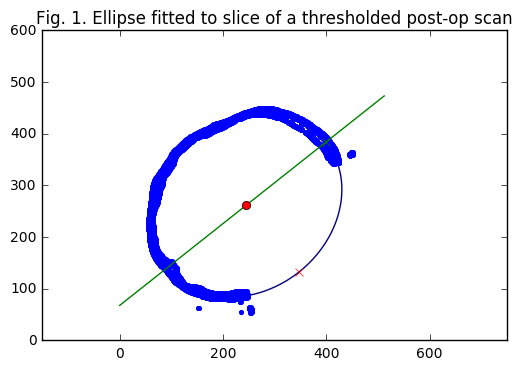

In [15]:
xcentroid = general_form_numpy[0][0]
ycentroid = general_form_numpy[0][1]
xaxis = general_form_numpy[1][0]
yaxis = general_form_numpy[1][1]
angle = general_form_numpy[2] #anticlockwise is positive

y = np.linspace(0,512)
x = np.linspace(0,512)
x,y = np.meshgrid(x,y)
plt.contour(x,y,(conic_numpy[0]*x**2 + conic_numpy[1]*x*y + conic_numpy[2]*y**2 + conic_numpy[3]*x + conic_numpy[4]*y + conic_numpy[5]),[0])
plt.plot(indices[1],indices[0], '.')
x = np.linspace(0,512)
y = ycentroid + (x-xcentroid)*np.tan(angle+np.pi/2)
plt.plot(x,y)
plt.plot(xcentroid, ycentroid, 'o')
if xaxis>yaxis:
    plt.plot(xcentroid+yaxis*np.cos(angle+np.pi/2),ycentroid+yaxis*np.sin(angle+np.pi/2),'x',color='red')
    plt.plot(xcentroid+xaxis*np.cos(angle),ycentroid+xaxis*np.sin(angle),'x', color='green')
else:
    plt.plot(xcentroid+xaxis*np.cos(angle),ycentroid+xaxis*np.sin(angle),'x',color='red')
    plt.plot(xcentroid+yaxis*np.cos(angle+np.pi/2),ycentroid+yaxis*np.sin(angle+np.pi/2),'x', color='green')
print yaxis, xaxis
print angle, angle/(2*np.pi)*360
plt.axis('equal')
plt.title('Fig. 1. Ellipse fitted to slice of a thresholded post-op scan')
plt.show()

In [20]:
reload(script)
from script import orientation
angles=np.zeros(post_700.shape[2])
xcentroids=np.zeros(post_700.shape[2])
ycentroids=np.zeros(post_700.shape[2])
xmajor_axis_points=np.zeros(post_700.shape[2])
ymajor_axis_points=np.zeros(post_700.shape[2])

for i in range(post_700.shape[2]):
    try:
        array_i=post_700[:,:,i] # array to pass to 'orientation' must be thresholded already
        orientation_i=orientation(array_i)
        angles[i]=orientation_i[2] # pick out the angle
        xcentroids[i]=orientation_i[0][0]
        ycentroids[i]=orientation_i[0][1]
        xmajor_axis_points[i] = xcentroids[i]+orientation_i[1][1]*np.cos(angle)
        ymajor_axis_points[i] = ycentroids[i]+orientation_i[1][1]*np.sin(angle)
    except:
        pass

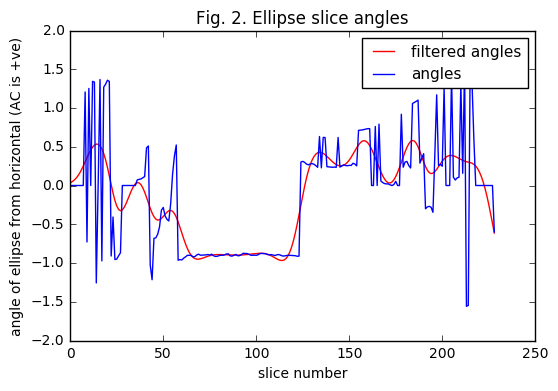

In [21]:
import scipy.signal as signal
# First, design the Butterworth filter
N  = 3   # Filter order - the higher the order, the sharper the dropoff
pd = float(20)  # Cutoff period - the inverse is the cutoff frequency
fs = 1 # Sample rate frequency
nyq = 0.5*fs
low = 1/pd
wn = low/nyq # Cutoff frequency as a fraction
b, a = signal.butter(N, wn, output='ba')
filt_angles = signal.filtfilt(b,a, angles)
plt.plot(filt_angles,'r-',label='filtered angles')
plt.plot(angles,'b-', label = 'angles')
plt.xlabel('slice number')
plt.ylabel('angle of ellipse from horizontal (AC is +ve)')
plt.legend(fontsize=11)
plt.title('Fig. 2. Ellipse slice angles')
plt.show()

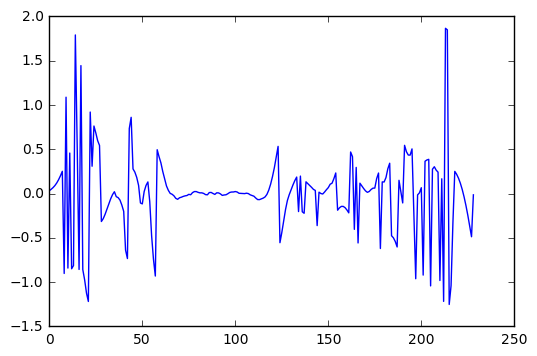

In [22]:
angles_diff = filt_angles-angles
plt.plot(angles_diff)
plt.show()

In [23]:
indices = [] # indices holds the slice range of interest
for i in range(len(angles)):
    if abs(angles_diff[i]) < 0.05:
        indices.append(i)
from itertools import groupby
z = zip(indices, indices[1:])
tmp = [list(j) for i, j in groupby(z, key=lambda x: (x[1] - x[0]) <= 1)]
tmp = max(tmp, key=len)
indices = list(range(tmp[0][0], tmp[-1][-1]+1))
print indices

[70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110]


In [24]:
head_angles = angles[indices]
head_x = xcentroids[indices]
head_y = ycentroids[indices]
head_angles = angles[indices]
mean_angle = np.mean(head_angles)
print mean_angle/(2*np.pi)*360

-51.2585520518


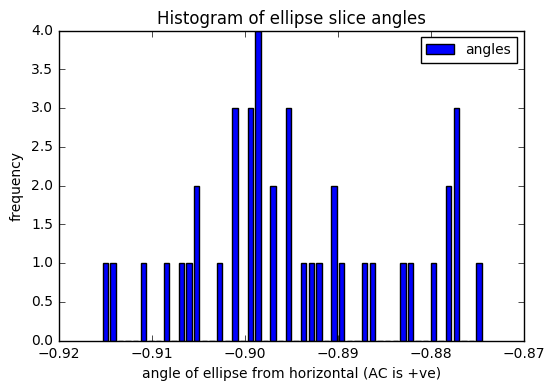

In [25]:
hist, bins = np.histogram(angles[indices], bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width, label='angles')
plt.xlabel('angle of ellipse from horizontal (AC is +ve)')
plt.ylabel('frequency')
plt.legend(fontsize=10)
plt.title('Histogram of ellipse slice angles')
plt.show()


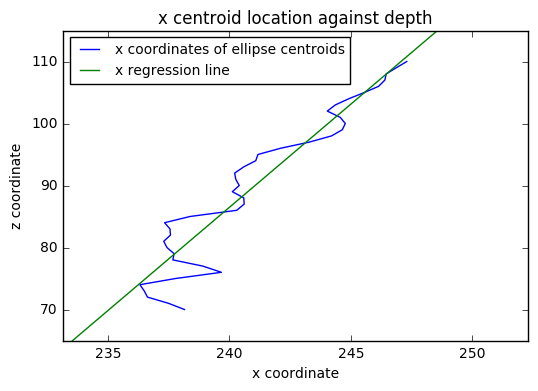

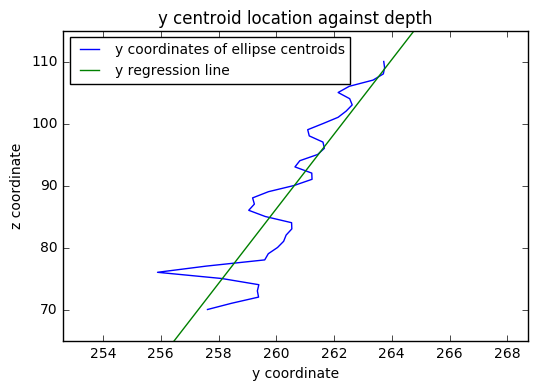

In [26]:
# find a plane
from scipy.optimize import curve_fit
def f(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B
A_x,B_x = curve_fit(f, head_x, indices)[0] # your data x, y to fit
A_y,B_y = curve_fit(f, head_y, indices)[0] # your data x, y to fit

plt.plot(head_x, indices, label='x coordinates of ellipse centroids')
plt.plot(x, A_x*x + B_x, label='x regression line') 
plt.xlim(head_x[0]-5,head_x[-1]+5)
plt.ylim(indices[0]-5,indices[-1]+5)
plt.legend(fontsize=10, loc=2)
plt.xlabel('x coordinate')
plt.ylabel('z coordinate')
plt.title('x centroid location against depth')
plt.show()

plt.plot(head_y, indices, label='y coordinates of ellipse centroids')
plt.plot(x, A_y*x + B_y, label='y regression line') 
plt.xlim(head_y[0]-5,head_y[-1]+5)
plt.ylim(indices[0]-5,indices[-1]+5)
plt.legend(fontsize=10, loc=2)
plt.xlabel('y coordinate')
plt.ylabel('z coordinate')
plt.title('y centroid location against depth')
plt.show()

90.0 241.055409529 260.625682103


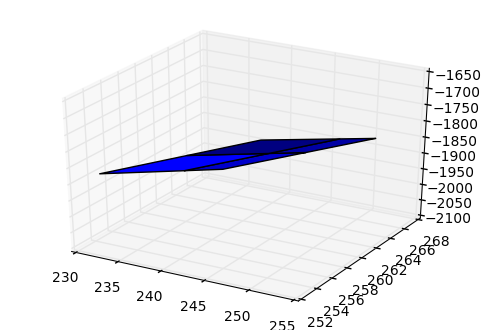

In [27]:
from mpl_toolkits.mplot3d import Axes3D

centre_z = np.median(indices)
centre_x = (centre_z-B_x)/A_x
centre_y = (centre_z-B_y)/A_y
print centre_z, centre_x, centre_y

# one vector of plane, v1
v1 = np.array([1/A_x, 1/A_y, 1])
# second vector of plane, v2
v2 = np.array([np.cos(mean_angle+np.pi/2), np.sin(mean_angle+np.pi/2), 0])
# point that the plane goes through, p
p = np.array([centre_x, centre_y, centre_z]) # coordinates when z = mean(indices)
normal = np.cross(v1,v2)
# a plane is ax+by+cz = d - find d
d = np.dot(p,normal)

xx = range(int(head_x[0])-5,int(head_x[-1])+5,1)
yy = range(int(head_y[0])-5,int(head_y[-1])+5,1)
[xx,yy] = np.meshgrid(xx,yy)
z = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(xx, yy, z)
plt.show()


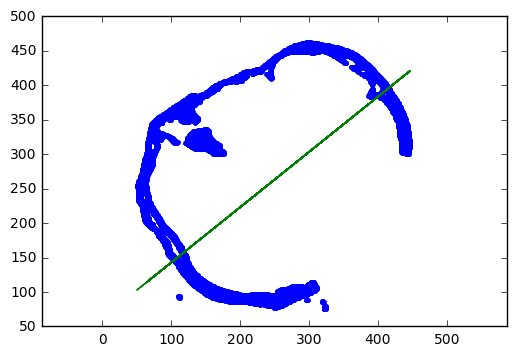

In [28]:
# superpose plane onto slices
a = normal[0]
b = normal[1]
c = normal[2]
# plane equation is ax+by+cz = d
# for each slice substitute slice number into z to get equation

slice_no = 150
numpy_array=post_700[:,:,slice_no]
skull = np.nonzero(numpy_array)
x = skull[1]
y = skull[0]
plt.plot(x,y, '.')
plt.axis('equal')
plt.plot(x, (d-c*slice_no-a*x)/b)
plt.show()


In [29]:
array = script.dicom2np(PostPathDicom)

In [30]:
from plotly.graph_objs import *

slice_no = 160
slice_ = array[:,:,slice_no]


heatmap = Heatmap(
        z = slice_,
        colorscale = 'Greys'
        )

x = np.linspace(0,slice_.shape[0], 2)
y = (d-c*slice_no-a*x)/b

midline = Scatter(
    x = x,
    y = y,
    mode = 'lines'
)

layout = Layout(
    width = 600,
    height= 600,
    title='Fig. 3. Slice number %i' % slice_no
)
data = [heatmap, midline]
fig = Figure(data=data, layout=layout)
plotly.offline.iplot(fig)


In [ ]:
# plotly.offline.init_notebook_mode()
# from plotly.graph_objs import *

# for slice_no in range(140,162,2):
#     slice_ = array[:,:,slice_no]

#     heatmap = Heatmap(
#             z = slice_,
#             colorscale = 'Greys'
#             )

#     x = np.linspace(0,slice_.shape[0], 2)
#     y = (d-c*slice_no-a*x)/b

#     midline = Scatter(
#         x = x,
#         y = y,
#         mode = 'lines'
#     )

#     layout = Layout(
#         width = 600,
#         height= 600,
#         title='Slice number %i' % slice_no
#     )
#     data = [heatmap, midline]
#     fig = Figure(data=data, layout=layout)
#     plotly.plotly.image.save_as(fig, filename='{0}_smallrange.png'.format(slice_no))

# plotly.offline.iplot(fig)

In [ ]:
# to do
# write a function to find a plane of symmetry. optimise parameters using scipy optimise
# optimise x0, y0, z0, m, n where m is tilt and n is orientation
# send out email with meeting minutes